# Analysis of 2ns Production Run (45° Rotation of G527)
*Elliot Williams*

Here, I analyze the 2ns of production run of the rotated G527 N1 ribosomal neighbourhood, using [Principal Components Analysis (PCA)](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues) and [pytraj].

First, let's load the relevant trajectories into Python (sourced from `home33/weirlab/MDfiles/5JUP_N1/UMBRELLA_G63/` on cottontail)

In [2]:
%load_ext rpy2.ipython

In [3]:
import pytraj as pt
# Loads in trajectories for first 2ns of post-rotational dynamics
traj = pt.iterload(["data/105-dyn1.trj", "data/105-dyn2.trj"], "data/5JUP_N1_wat.prmtop",
                   frame_slice=[(0, 500, 1),]*2)

Note that the original trajectory has a Topology associated with almost 100,000 atoms. This is because each of the atoms within each amino acid and nucleotide is considered; let's fix this by only considering the alpha carbon of each amino acid, and only the C1' of each nucleotide.

In [4]:
traj_n1 = traj["@CA,C1'"]
traj_n1

pytraj.Trajectory, 1000 frames: 
Size: 0.011064 (GB)
<Topology: 495 atoms, 495 residues, 495 mols, PBC with box type = truncoct>
           

Success! Now, let's use the Euclidean position of each of the atoms over the trajectory as input dimensions to PCA.

In [5]:
# compute pca (compute all eigenvectors, eigenvalues)
data = pt.pca(traj, mask="@CA,C1'", n_vecs=-1)

In [6]:
import matplotlib
from matplotlib import pyplot as plt

eigenvalues = data[1][0]
variance_explained = [eigenvalues[i] / sum(eigenvalues) for i in range(len(eigenvalues))]

print("There are {} eigenvalues total".format(len(eigenvalues)))

plt.plot([x for x in range(50)], variance_explained[0:50], marker='o', alpha=0.5)
plt.xlabel("Principal Component Index")
plt.ylabel("Explained Variance (per component)")
plt.title("Scree Plot of Atomic Position Variance")


There are 1485 eigenvalues total


Text(0.5,1,'Scree Plot of Atomic Position Variance')

Analyzing the Scree plot, 5 principal components would be the most appropriate measure. 

Unfortunately we can only visualize 2, but let's cluster to 5 anyways.

In [7]:
print("{:.5f} of the variance is explained by 2 principal components".format(
    sum(variance_explained[0:2])))
print("{:.5f} of the variance is explained by 5 principal components".format(
    sum(variance_explained[0:5])))

0.32669 of the variance is explained by 2 principal components
0.44640 of the variance is explained by 5 principal components


Now, let's visualize how the trajectory 'wanders' over the first two principal components over the 2ns of trajectory.

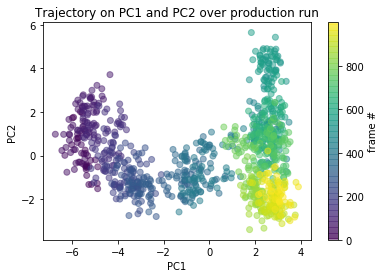

In [8]:
import matplotlib

projection_data = data[0]
from matplotlib import pyplot as plt

plt.scatter(projection_data[0], projection_data[1], marker='o', c=range(traj.n_frames), alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Trajectory on PC1 and PC2 over production run')
cbar = plt.colorbar()
cbar.set_label('frame #')    

We can solidly say that the simulation definitely 'wanders' over the course of the 2ns of dynamics. Now, let's cluster the frames within the trajectory on the first 5 principal components in order to obtain some typical values for each cluster which we can then use in our UMBRELLA sampling steps. 

Let's load our 5 PCs into a pandas DataFrame, and start with an Elbow curve to figure out exactly how many clusters we should use

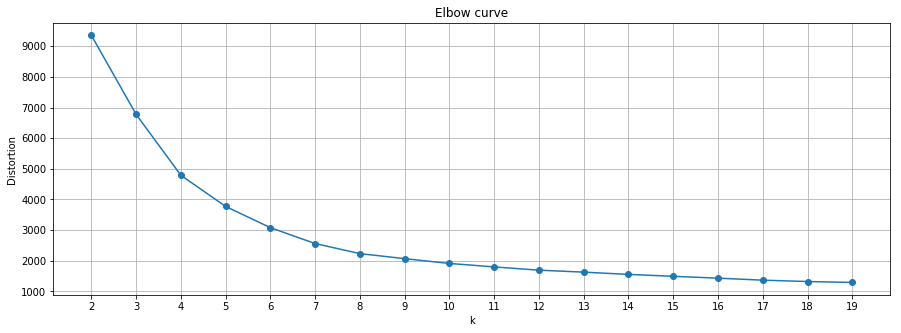

In [9]:
import pandas as pd
import sklearn
import seaborn
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist, pdist


df = pd.DataFrame(data={'PC1': projection_data[0],
                        'PC2': projection_data[1],
                        'PC3': projection_data[2],
                        'PC4': projection_data[3],
                        'PC5': projection_data[4],
                         })

distorsions = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df)
    distorsions.append(kmeans.inertia_)


fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions, marker='o')
plt.ylabel("Distortion")
plt.xlabel("k")
plt.grid(True)
plt.title('Elbow curve')
plt.xticks(range(2,20))
plt.show()

To me, there's no clear 'elbow' on this curve, but $k=5$ seems like a reasonable choice.

In [10]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df)
df['labels']  = pd.Series(kmeans.labels_)
df['frame_num'] = pd.Series(range(len(eigenvalues)))
df

,PC1,PC2,PC3,PC4,PC5,labels,frame_num
0,-5.982524,1.724795,2.618183,1.788422,0.422777,1,0
1,-5.929882,1.755445,2.841009,2.202875,0.411938,1,1
2,-5.630760,2.009926,2.871225,2.409804,0.018680,1,2
3,-5.566526,1.983892,2.803293,2.803631,-0.020195,1,3
4,-5.423696,1.121955,2.391388,2.452172,0.473166,1,4
5,-5.735798,0.814544,1.975376,1.766226,0.929716,1,5
6,-5.480517,1.213956,1.865251,2.264497,0.604405,1,6
7,-5.253806,1.058723,2.165323,2.725991,0.581041,1,7
8,-5.423862,0.251161,1.547447,1.870916,0.427899,1,8
9,-5.523530,1.332698,1.617487,1.820727,0.357385,1,9


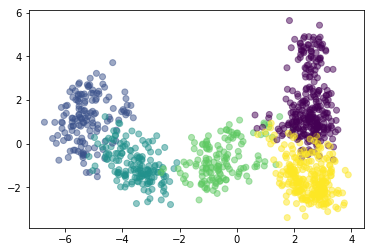

In [11]:
plt.scatter(projection_data[0], projection_data[1], marker='o', c=df['labels'], alpha=0.5)

NameError: name 'plt' is not defined